Generate Music with an RNN

In [121]:
!sudo apt install -y  fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [122]:
!pip install --upgrade pyfluidsynth

In [123]:
!pip install pretty_midi

In [124]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [125]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

Download the Maestro Dataset

In [126]:


data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():


  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',

  )

Dataset contains about 1200 MIDI files

In [127]:
filenames =glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


In [128]:
sample_file = filenames[1]
print(sample_file)

data/maestro-v2.0.0/2004/MIDI-Unprocessed_SMF_16_R1_2004_01-08_ORIG_MID--AUDIO_16_R1_2004_06_Track06_wav.midi


In [129]:
pm=pretty_midi.PrettyMIDI(sample_file)

In [130]:


def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_shorts = waveform[:seconds * _SAMPLING_RATE]
    return display.Audio(waveform_shorts, rate=_SAMPLING_RATE)

In [131]:
display_audio(pm)

In [132]:
print('Number of Instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of Instruments: 1
Instrument name: Acoustic Grand Piano


In [133]:
for instrument in pm.instruments:
    for i, note in enumerate(instrument.notes[:10]):
        note_name = pretty_midi.note_number_to_name(note.pitch)
        duration = note.end - note.start
        print(f'{i}: pitch={note.pitch}, note_name={note_name}, duration={duration:.4f}')


0: pitch=63, note_name=D#4, duration=0.0656
1: pitch=65, note_name=F4, duration=0.0667
2: pitch=63, note_name=D#4, duration=0.0698
3: pitch=62, note_name=D4, duration=0.0281
4: pitch=63, note_name=D#4, duration=0.0333
5: pitch=65, note_name=F4, duration=0.0500
6: pitch=63, note_name=D#4, duration=0.0458
7: pitch=65, note_name=F4, duration=0.0625
8: pitch=63, note_name=D#4, duration=0.0417
9: pitch=62, note_name=D4, duration=0.0375


Extract the sample notes from the sample MIDI  file.

In [134]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})



In [135]:
raw_notes  = midi_to_notes(sample_file)
raw_notes.head()


,pitch,start,end,step,duration
0,63,0.704167,0.769792,0.000000,0.065625
1,65,0.792708,0.859375,0.088542,0.066667
2,63,0.871875,0.941667,0.079167,0.069792
3,62,0.928125,0.956250,0.056250,0.028125
4,63,1.223958,1.257292,0.295833,0.033333


In [136]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]


array(['D#4', 'F4', 'D#4', 'D4', 'D#4', 'F4', 'D#4', 'C#4', 'F4', 'D#4'],
      dtype='<U3')

Visualizing the Musical Piece

In [137]:
def  plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20,4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

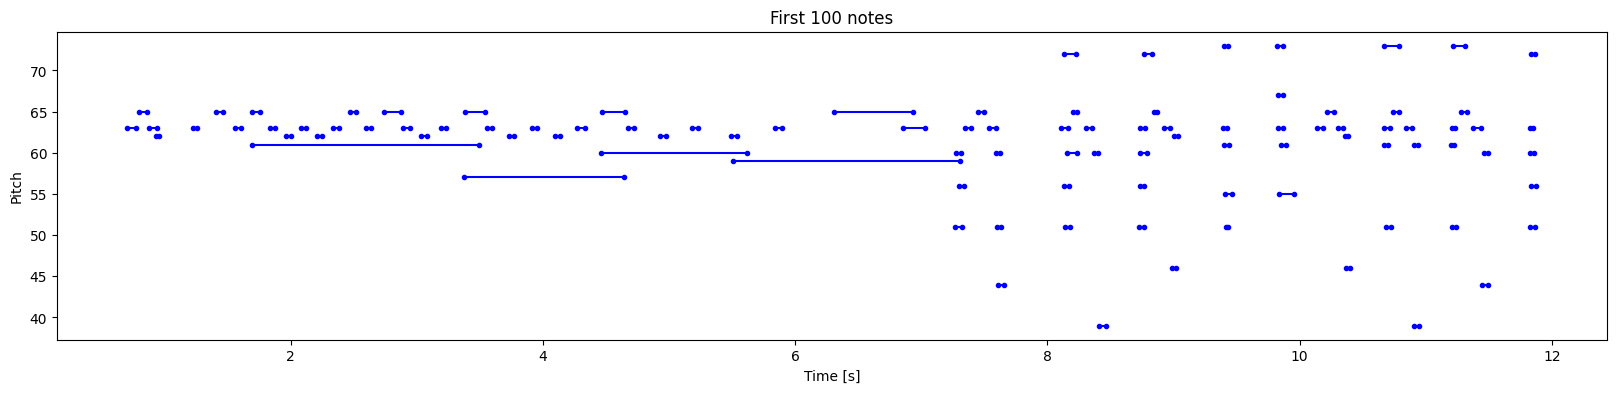

In [138]:
plot_piano_roll(raw_notes, count=100)

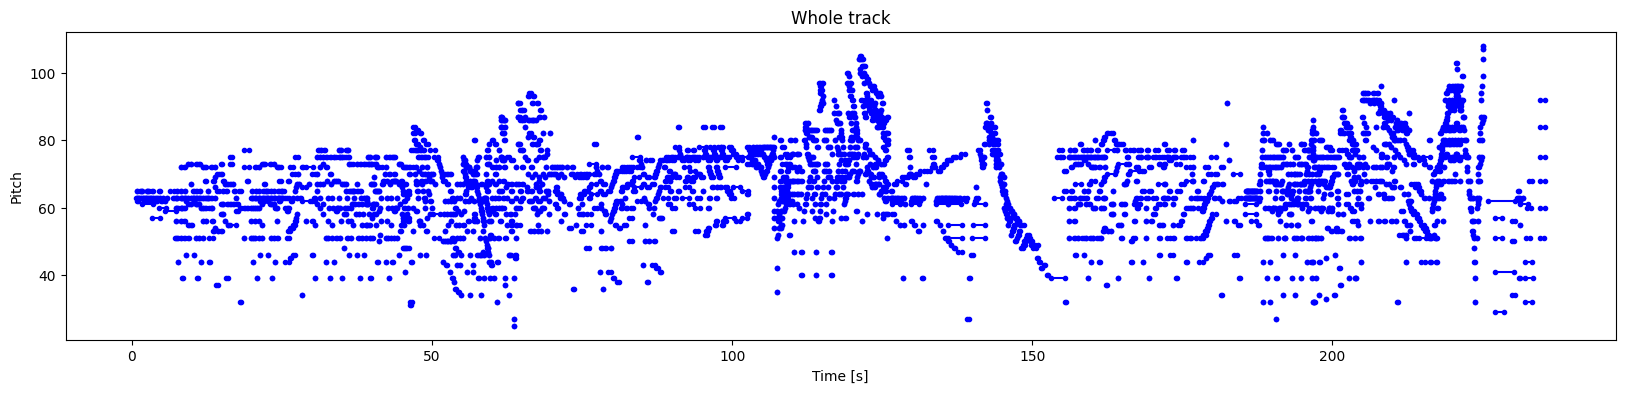

In [139]:
plot_piano_roll(raw_notes)

In [140]:
def plot_distributions(notes: pd.DataFrame,drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1,3,2)
  max_step = np.percentile(notes['step'], 100-drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1,3,3)
  max_duration = np.percentile(notes['duration'], 100-drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration,21))

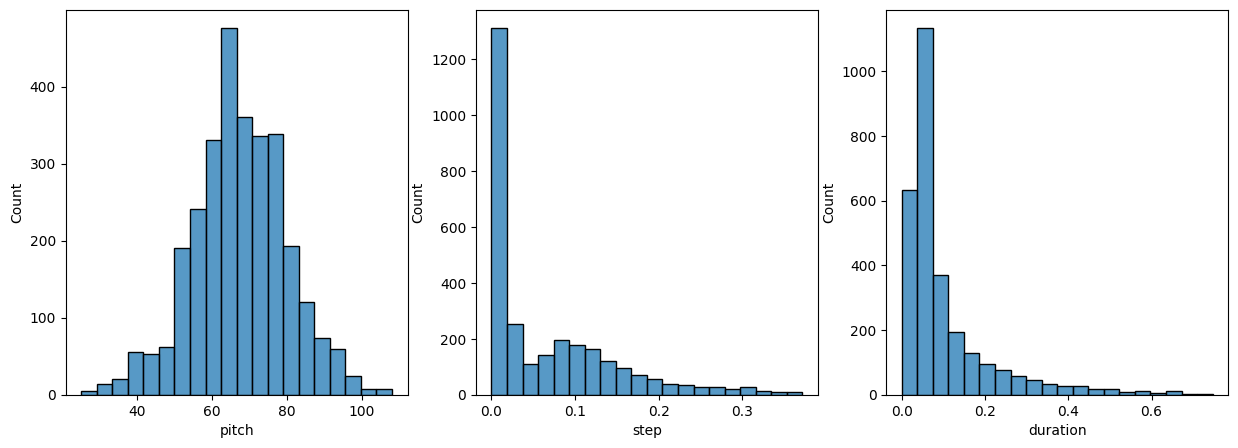

In [141]:
plot_distributions(raw_notes)

Create a MIDI file

In [142]:
def notes_to_midi(
    notes: pd.DataFrame,
    out_file: str,
    instrument_name: str,
    velocity: int = 100,
) -> pretty_midi.PrettyMIDI:
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program(instrument_name)
    )
    prev_start = 0
    for i, note in notes.iterrows():
        start = float(prev_start + note['step'])
        end = float(start + note['duration'])
        midi_note = pretty_midi.Note(
            velocity=velocity,
            pitch=int(note['pitch']),
            start=start,
            end=end,
        )
        instrument.notes.append(midi_note)
        prev_start = start

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm



In [143]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name
)

Play the generated MIDI file and see if there is any difference.

In [144]:
display_audio(example_pm)

In [145]:
num_files = 5

all_notes = []
for f in filenames[:num_files]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [146]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 35278


Next,Create a tf.data.Dataset  from the parsed notes

In [147]:
key_order =['pitch','step','duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [148]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [149]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)






In [150]:
seq_length = 25
vocab_size = 128

seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

# Check the dataset spec
seq_ds.element_spec


(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [151]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.203125   0.         9.725     ]
 [0.296875   0.27708333 9.54479167]
 [0.390625   0.31666667 0.26770833]
 [0.40625    0.22708333 0.175     ]
 [0.4140625  0.13958333 0.12708333]
 [0.4296875  0.12604167 0.14895833]
 [0.4453125  0.12604167 0.11875   ]
 [0.4609375  0.08958333 0.12291667]
 [0.4765625  0.096875   0.078125  ]
 [0.484375   0.08958333 0.21041667]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=74.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.10208333333333375>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.09375>}


In [152]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [153]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

Create and train the model
The model will have three outputs, one for each note variable. For step and duration, you will use a custom loss function based on mean squared error that encourages the model to output non-negative values.

In [154]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [155]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 25, 3)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 128)                  67584     ['input_1[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm[0][0]']                
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm[0][0]']                
                                                                                              

In [156]:
losses = model.evaluate(train_ds, return_dict=True)
losses

550/550 [==============================] - 17s 19ms/step - loss: 5.0790 - duration_loss: 0.1712 - pitch_loss: 4.8516 - step_loss: 0.0562


{'loss': 5.079030990600586,
 'duration_loss': 0.17116160690784454,
 'pitch_loss': 4.851645469665527,
 'step_loss': 0.056225087493658066}

In [157]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [158]:
model.evaluate(train_ds, return_dict=True)

550/550 [==============================] - 11s 19ms/step - loss: 0.4700 - duration_loss: 0.1712 - pitch_loss: 4.8516 - step_loss: 0.0562


{'loss': 0.4699687659740448,
 'duration_loss': 0.17116160690784454,
 'pitch_loss': 4.851645469665527,
 'step_loss': 0.056225087493658066}

In [159]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [166]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
550/550 [==============================] - 25s 46ms/step - loss: 0.2063 - duration_loss: 0.0240 - pitch_loss: 3.4446 - step_loss: 0.0100
Epoch 2/50
550/550 [==============================] - 25s 46ms/step - loss: 0.2072 - duration_loss: 0.0247 - pitch_loss: 3.4464 - step_loss: 0.0102
Epoch 3/50
550/550 [==============================] - 25s 45ms/step - loss: 0.2060 - duration_loss: 0.0243 - pitch_loss: 3.4329 - step_loss: 0.0100
Epoch 4/50
550/550 [==============================] - 25s 45ms/step - loss: 0.2087 - duration_loss: 0.0264 - pitch_loss: 3.4394 - step_loss: 0.0103
Epoch 5/50
550/550 [==============================] - 24s 43ms/step - loss: 0.2084 - duration_loss: 0.0263 - pitch_loss: 3.4343 - step_loss: 0.0103
Epoch 6/50
550/550 [==============================] - 25s 46ms/step - loss: 0.2085 - duration_loss: 0.0263 - pitch_loss: 3.4297 - step_loss: 0.0107
Epoch 7/50
550/550 [==============================] - 25s 46ms/step - loss: 0.2077 - duration_loss: 0.0264 - pit

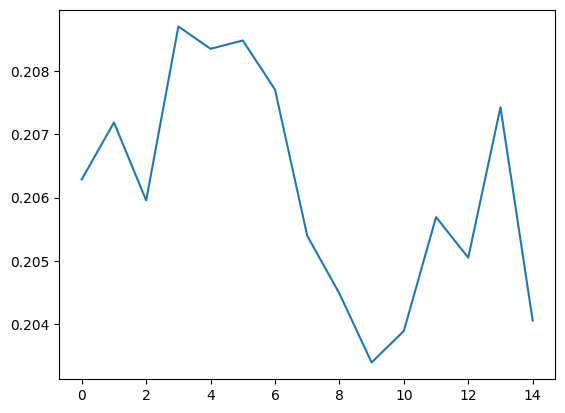

In [167]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [182]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0
) -> tuple[int, float, float]:
    """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

    assert temperature > 0

    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs)
    pitch_logits = predictions['pitch']
    step = predictions['step']
    duration = predictions['duration']

    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    step = tf.squeeze(step, axis=-1)

    # `step` and `duration` values should be non-negative
    step = tf.maximum(0, step)
    duration = tf.maximum(0, duration)

    return int(pitch), float(step), float(duration)


In [186]:
temperature = 3
num_predictions = 240  # Increase the number of predictions to extend the duration

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
    pitch, step, duration = predict_next_note(input_notes, model, temperature)
    start = prev_start + step
    end = start + duration
    input_note = (pitch, step, duration)
    generated_notes.append((*input_note, start, end))
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
    prev_start = start

# Convert the list of generated notes to a DataFrame
generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 26ms/step


In [187]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,41,0.063735,0.065527,0.063735,0.129262
1,87,0.081372,0.000000,0.145107,0.145107
2,44,0.073479,0.028411,0.218586,0.246996
3,94,0.085759,0.000000,0.304345,0.304345
4,37,0.073826,0.016772,0.378171,0.394943
5,73,0.080748,0.000000,0.458919,0.458919
6,24,0.053972,0.062410,0.512892,0.575301
7,104,0.061890,0.000000,0.574781,0.574781
8,92,0.050830,0.000000,0.625612,0.625612
9,104,0.034395,0.000000,0.660007,0.660007


In [188]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [189]:
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

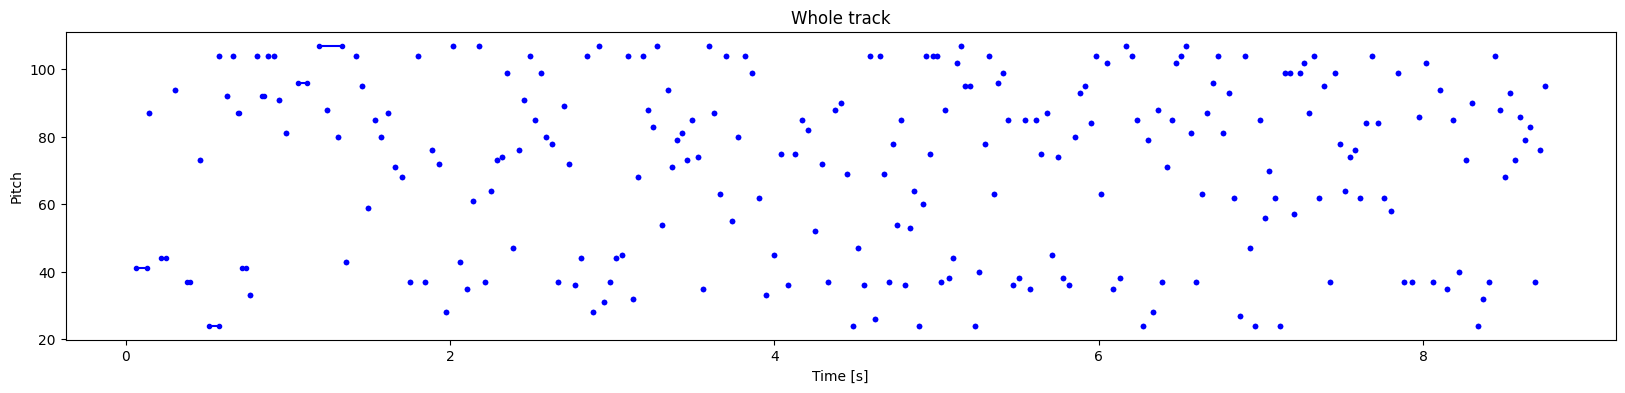

In [190]:
plot_piano_roll(generated_notes)

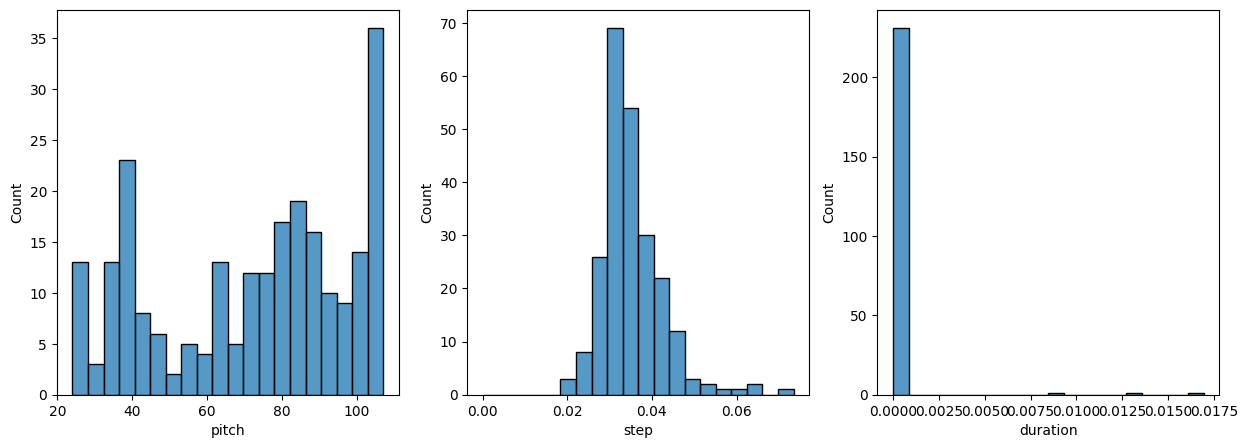

In [191]:
plot_distributions(generated_notes)